In [1]:
# importing dependencies for file access, model, visualisations
import pandas as pd
import tensorflow as tf
import keras.backend as K
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, TFBertForSequenceClassification
from datasets import Dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


# importing dependencies for testing
import chardet

In [2]:
def load_data_from_directory(base_dir):
    """
    Load data and integer labels from the directory structure.

    Parameters:
    - base_dir: The directory containing label-based subdirectories

    Returns:
    - texts: A list of texts from the files
    - labels: A corresponding list of integer labels
    """
    texts = []
    labels = []

    # Loop through each directory in the base directory
    for label_dir in os.listdir(base_dir):
        # Ensure it's actually a directory
        if os.path.isdir(os.path.join(base_dir, label_dir)):
            # Extract label from the directory name (here we extract the prefixing number)
            label_int = int(label_dir.split('_')[0]) - 1  # subtracting 1 to make labels start from 0

            # Loop through each file in the directory
            for filename in os.listdir(os.path.join(base_dir, label_dir)):
                if filename.endswith(".txt"):
                    with open(os.path.join(base_dir, label_dir, filename), 'r', encoding='utf-8') as file:
                        texts.append(file.read())
                        labels.append(label_int)

    return texts, labels


base_dir = "/Users/jeromejaggi/Desktop/MSc Dissertation/6_Data"
texts, labels = load_data_from_directory(base_dir)
print("✅ Loaded", len(texts), "documents.")





✅ Loaded 51 documents.


In [3]:
# Ensure all file encodings are UTF-8

def detect_file_encodings(base_dir):
    encodings = {}

    for label_dir in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, label_dir)):
            for filename in os.listdir(os.path.join(base_dir, label_dir)):
                if filename.endswith(".txt"):
                    file_path = os.path.join(base_dir, label_dir, filename)

                    # Detect encoding of the file
                    with open(file_path, 'rb') as file:
                        result = chardet.detect(file.read())
                        file_encoding = result['encoding']
                        encodings[file_path] = file_encoding

    return encodings

base_dir = "/Users/jeromejaggi/Desktop/MSc Dissertation/6_Data"
file_encodings = detect_file_encodings(base_dir)

# Print out the files and their detected encodings if not ascii or utf-8
counter = 0
for file, encoding in file_encodings.items():
    if encoding == "ascii" or encoding =="utf-8":
        counter += 1
    else:
        print(f" ❌ {file}: {encoding}")
        
print(f"✅ {counter} files checked and confirmed ascii or utf-8")

✅ 51 files checked and confirmed ascii or utf-8


In [4]:
# Convert all files to UTF-8 encoding, commented out after use

def convert_to_utf8(file_path):
    with open(file_path, 'rb') as file:
        content = file.read()
        detected_encoding = chardet.detect(content)['encoding']

        # Handle potential None value
        if not detected_encoding:
            detected_encoding = 'utf-8'

    # Decode with detected encoding and then re-encode in UTF-8
    content_decoded = content.decode(detected_encoding, errors='replace')
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content_decoded)

directory_path = "/Users/jeromejaggi/Desktop/MSc Dissertation/6_Data"
for root, dirs, files in os.walk(directory_path):
    for filename in files:
        if filename.endswith(".txt"):
            file_path = os.path.join(root, filename)
            #convert_to_utf8(file_path) #no longer needed in final code


In [5]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the texts
encoded_texts = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors='tf')

# Split data into training and validation sets
input_ids_np = np.array(encoded_texts['input_ids'])
labels_np = np.array(labels)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids_np, 
    labels_np, 
    test_size=0.2, 
    random_state=42
)

print(" ✅Data has been tokenized and split into training and validation sets.")

 ✅Data has been tokenized and split into training and validation sets.


2023-08-18 19:22:59.251078: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-08-18 19:22:59.251103: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-08-18 19:22:59.251112: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-08-18 19:22:59.251147: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-18 19:22:59.251177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# Initialize BERT model for classification with 4 categories
#model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

#optimizer = Adam(learning_rate=5e-6, epsilon=1e-08)
#loss = 'sparse_categorical_crossentropy'  # since our labels are integers (0, 1, 2, 3)
#metric = 'accuracy' # use different metric?

# Testing alternative metric for model performance, F1 score gives a balanced measurement between accuracy and recall
# f1_score = tf.keras.metrics.F1Score(average="micro")

#model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Should I use different metrics and/or optimizer?

In [7]:
# Testing k-fold-crossvalidation to train the model on a larger dataset while retaining some validation

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# iterate over the train-test splits and train the model for each split
input_ids_np = np.array(encoded_texts['input_ids'])
labels_np = np.array(labels)

fold = 0
for train_index, val_index in kf.split(input_ids_np):
    fold += 1
    print(f"Training for fold {fold}")

    # Create data for this fold
    train_inputs, val_inputs = input_ids_np[train_index], input_ids_np[val_index]
    train_labels, val_labels = labels_np[train_index], labels_np[val_index]
    
    # Initialize model for each fold
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
    optimizer = Adam(learning_rate=5e-6, epsilon=1e-08)
    loss = 'sparse_categorical_crossentropy'
    metric = ['accuracy']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metric)
    
    # Train the model on this fold's data
    model.fit(train_inputs, train_labels, epochs=3, batch_size=16, validation_data=(val_inputs, val_labels))


Training for fold 1


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


2023-08-18 19:23:08.290951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 4.1203 - accuracy: 0.3250

2023-08-18 19:25:35.148226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 178s 47s/step - loss: 4.1203 - accuracy: 0.3250 - val_loss: 2.1833 - val_accuracy: 0.2727
Epoch 2/3
3/3 [==============================] - 13s 2s/step - loss: 2.4483 - accuracy: 0.3500 - val_loss: 1.3863 - val_accuracy: 0.0909
Epoch 3/3
3/3 [==============================] - 7s 2s/step - loss: 2.2643 - accuracy: 0.2000 - val_loss: 1.3863 - val_accuracy: 0.0909
Training for fold 2


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


2023-08-18 19:26:29.700758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 4.2323 - accuracy: 0.2927

2023-08-18 19:29:10.926258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 202s 55s/step - loss: 4.2323 - accuracy: 0.2927 - val_loss: 1.2477 - val_accuracy: 0.4000
Epoch 2/3
3/3 [==============================] - 11s 2s/step - loss: 3.5377 - accuracy: 0.2683 - val_loss: 1.3863 - val_accuracy: 0.3000
Epoch 3/3
3/3 [==============================] - 6s 2s/step - loss: 1.8095 - accuracy: 0.3415 - val_loss: 1.3863 - val_accuracy: 0.3000
Training for fold 3


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


2023-08-18 19:30:10.826975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 8.9635 - accuracy: 0.2439

2023-08-18 19:33:06.841207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 219s 61s/step - loss: 8.9635 - accuracy: 0.2439 - val_loss: 3.0054 - val_accuracy: 0.4000
Epoch 2/3
3/3 [==============================] - 13s 3s/step - loss: 6.0818 - accuracy: 0.2439 - val_loss: 2.1342 - val_accuracy: 0.5000
Epoch 3/3
3/3 [==============================] - 9s 3s/step - loss: 5.6627 - accuracy: 0.2439 - val_loss: 1.7839 - val_accuracy: 0.6000
Training for fold 4


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


2023-08-18 19:34:11.732234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 11.2425 - accuracy: 0.0976     

2023-08-18 19:37:26.652244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 240s 64s/step - loss: 11.2425 - accuracy: 0.0976 - val_loss: 9.7104 - val_accuracy: 0.1000
Epoch 2/3
3/3 [==============================] - 13s 3s/step - loss: 8.1157 - accuracy: 0.2439 - val_loss: 7.9930 - val_accuracy: 0.2000
Epoch 3/3
3/3 [==============================] - 9s 3s/step - loss: 7.0196 - accuracy: 0.2683 - val_loss: 5.4732 - val_accuracy: 0.2000
Training for fold 5


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


2023-08-18 19:38:35.326904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 6.1846 - accuracy: 0.1951

2023-08-18 19:42:27.340871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 281s 76s/step - loss: 6.1846 - accuracy: 0.1951 - val_loss: 1.2501 - val_accuracy: 0.3000
Epoch 2/3
3/3 [==============================] - 14s 3s/step - loss: 3.4887 - accuracy: 0.4634 - val_loss: 1.2306 - val_accuracy: 0.3000
Epoch 3/3
3/3 [==============================] - 9s 3s/step - loss: 2.4336 - accuracy: 0.5854 - val_loss: 2.6040 - val_accuracy: 0.3000


In [8]:
# Train the model
#history = model.fit(
#    train_inputs, 
#    train_labels, 
#    validation_data=(val_inputs, val_labels), 
#    epochs=25, 
#    batch_size=8 
#)

In [9]:
# Confusion matrix

predictions = model.predict(val_inputs)
y_pred = predictions.logits

y_pred_classes = np.argmax(y_pred, axis=1)

y_true_classes = val_labels

matrix = confusion_matrix(y_true_classes, y_pred_classes).numpy()

2023-08-18 19:43:35.030561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 42s 42s/step


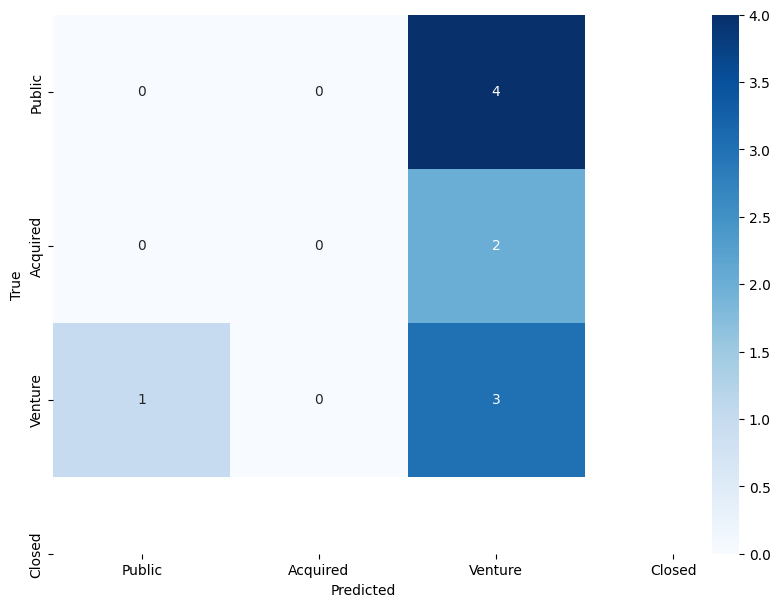

In [10]:
# Plot confusion matrix

class_names = ['Public', 'Acquired', 'Venture', 'Closed']

plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Confusion Matrix

A confusion matrix is a visualization tool used to assess classification model performance. Each row represents the actual classes, while each column signifies the predicted classes.

**Diagonal Elements**: Represent correct predictions (True Positives for each class).

**Off-Diagonal Elements**: Indicate misclassifications. The element in row x and column y shows the instances where the actual class x was predicted as class y.

A well-performing model will have higher values on the diagonal compared to off-diagonal elements, indicating accurate predictions.